# Hypothesis Test : The Basics Part 1: Fisher's Exact Test

This notebook will take heavy inspiration from:
- Professor Imai's notes on Statistical Hypothesis Tests [here](https://imai.fas.harvard.edu/teaching/files/tests.pdf)
- notes on hypothesis tests from UofU [here](https://users.cs.utah.edu/~jeffp/teaching/cs3130/lectures/L15-HypothesisTests1.pdf)
- the Wikipedia page on hypothesis tests [here](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)
- the Wikipedia page on Fisher's exact tests [here](https://en.wikipedia.org/wiki/Fisher%27s_exact_test)

## Import libraries

In [1]:
## import libraries
import pandas as pd
import numpy as np
from scipy.stats import hypergeom, norm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Intro - Fisher (1935)'s Lady Tasting Tea Example

Note that all hypothesis tests are based on a *stochastic proof by contradiction*. 

This means that we prove it by first assuming the validity of a hypothesis we would like to disaprove and derive a contradiction under the same hypothesis. It is *stochastic* because there is always uncertainty involved.

In 1935, Fisher demonstrates his framework for hypothesis testing (technically, I believe his testing was called significance testing) with a Lady tasting tea. He gave an example of a lady who claimed she could tell if tea was poured first (`T`) or if milk was poured first (`M`). To test this, the design was to take 4 tea's where tea was poured first and 4 tea's where milk was poured first and see how many she can identify. Fisher uses the $p$-value to help make this decision.

The $p$-value is defined as the probability of observing the outcome that is at least as extreme as the outcome you actually observed under the null hypothesis.

For instance, let's say she guessed all 8 cups correctly. Let's say that our null hypothesis is that there is no "trick" to guessing it correctly and that it is just random chance. Then, what this means is that all ways to select the 4 cups that started with milk or tea is the same. So as an example, if the order of the cups presented to her was `MTMTMTMT`, then the chance of her picking `TMTMTMTM` is the same as `TTTTMMMM`. 


Now, in the combinatorics world, this means that there are $8!=40320$ ways to rearrange the cups. However, since there are only 2 groups and we assume cups within each group are indistinguishable, we have to remove the duplicates (for example, `MMMMTTTT` is still `MMMMTTTT` even if we exchange the first and second cups since they are both `M`). This can be seen as $\frac{8!}{4!4!}= {8\choose 4}=70$ different ways to arrange the cups.

To calculate our $p$-value, notice how the # of ways for her to guess all 8 cups correctly is $1$ out of $70$ ways and there are no scenarios more extreme (no way to get more cups correct since 8 is the max). Therefore, the $p$-value is $1/70\approx 0.0142$. With this, Fisher concluded that the observed data is inconsistent with the hypothesis that the lady had no ability. 

The above procedure is referred to as *Fisher's exact test* because regardless of sample size, the test computes the exact $p$-value for testing the null hypothesis. It is also called a *permutation test* because it computes all the permutations of treatment assignments. 


## The Statistical Hypothesis Test Procedure

A hypothesis test has 6 steps:

1. Choose a null hypothesis $H_0$ and its alternative $H_1$. 
2. Choose a threshold $\alpha$, the maximal probability of Type 1 Error one is willing to tolerate (falsely rejecting the null when the null is true).
3. Choose a test statistic, which is a function of observed data.
4. Derive a distribution of the test statistic under the null hypothesis, which is referred to as the reference distribution. This is not a function of the observed data
5. Compute the $p$-value by comparing the observed value of the test statistic against its reference distribution
6. Reject the null hypothesis if the $p$-value is less than the pre-specified threshold $\alpha$ and retain the null hypothesis otherwise

## Fisher's Lady Tasting Tea Example with the above Procedure

Now we can revisit Fisher's Tea example using the above 6 steps.

#### **1. Choose a null hypothesis $H_0$ and its alternative $H_1$:**

$H_0:Y_i(1)-Y_i(0)=0$

$H_1:Y_i(1)-Y_i(0)\neq 0\text{ for at least some }i$

To avoid any confusion, $Y_i(t)$ is a potential outcome, which means that the null can be interpreted as, for each user $i$ (which in this case is a cup), regardless if tea was poured first ($t=1$) or milk was poured first ($t=0$), the outcome (how the lady categorizes the cup) would be the same $Y_i(1)=Y_i(0)$, meaning she cannot tell if the cup had milk or tea poured first. This means that according to the null, for every single cup, the lady shouldn't be able to tell the true nature of if the cup had tea or milk first and have to resort to guessing. 

This means that the null is a *sharp* null, meaning that the hypothesis is specified for each unit. A sharp null hypothesis is strong in that it assumes zero effect for every unit $i$. The usefulness of *sharp* null set-ups is controversial, and was one of the topics of the bitter debates between Fisher and Neyman/Pearson.

Of-course, in this tea scenario, it is not controversial - it's reasonable to use as the null that the lady shouldn't be able to tell the true nature of every cup.

In addition, notice how this makes it clear that we are working with a binary outcome (as well as a binary treatment). Generalizations to other forms of outcome will be discussed later on.

#### **2. Choose a threshold $\alpha$**

we choose $\alpha = 0.05$ as the threshold, allowing for up to 5 percent Type I error rate.

#### **3. Choose test statistic, a function of observed data**

In this example, the test statistic is the # of correctly classified cups from the observed data which is $8$

#### **4. Derive the reference distribution**

The distribution of # of correctly classified cups under the null is the following:

$P(0)=\frac{1}{70},P(2)=\frac{16}{70},P(4)=\frac{36}{70},P(6)=\frac{16}{70},P(8)=\frac{1}{70}$

#### **5. Compute the $p$-value by comparing the observed value of the test statistic against its reference distribution**

The $p$ value would be adding up all the probabilities that are 8 and above. Since 8 is the highest,

$P(S\geq 8)=\frac{1}{70}$

#### **6. Reject the null hypothesis if the $p$-value is less than the pre-specified threshold $\alpha$ and retain the null hypothesis otherwise**

We see that the $p$-value of $1/70\approx 0.0142$ is less than $\alpha=0.05$, thus we reject the null hypothesis.

## Generalizing the the above test to an arbitrary sample of $n$.

For the final part of this notebook, we will show the generalization of the above method for an arbitrary $n$. Note that we are still assuming binary outcome. 

Suppose we run a randomized experiment with $n$ units with the sharp null $H_0:Y_i(1)-Y_i(0)=0$. 

If the test statistic is defined as $S=\sum_{i=1}^{n}T_iY_i$ which amounts to the # of users in treatment ($T_i=1$) who got outcome ($Y_i=1$), under the above null setup, the reference distribution is defined as a *hyper-geometric distribution* whose probability mass function is given by

$$P(S=s)=\frac{{m\choose s}{n-m\choose n_1-s}}{n\choose n_1}$$

where
- $n_1$ is the # of users who got treatment $T_i=1$
- $m=\sum_{i=1}^{n}Y_i$ is the # of users who got outcome $Y_i=1$
- $s$ is the # of users in treatment ($T_i=1$) who got outcome ($Y_i=1$)

Thus,
- $n-m$ is the # of users who got the other outcome $Y_i=0$
- $n_1-s$ is the # of users who got treatment $T_i=1$ who got the other outcome $Y_i=0$

Notice how when $n=8,n_1=4,m=4,s=4$ for the tea example we get $P(S=4)=\frac{{4\choose 4}{4\choose 0}}{8\choose 4}=\frac{1}{70}$. Note that $P(S=4)$ and $P(S=8)$ because we defined the test statistic $S$ slightly different here compared to before, but it's conceptually the same.

(In addition, our reference distribution can actually be approximated by the $\text{Binomial}\left(n_1,\frac{m}{n}\right)$ when $n$ is large and $\frac{n_1}{n}$ is small)

Note that as $n$ grows, the exact distribution is more computationally intensive. Thankfully, we have the analytic exact mean and variance of the hyper-geometric distribution:
$$E(S)=\frac{n_1m}{n}, \text{  Var}(S)=\frac{mn_1(n-n_1)}{n(n-1)}\left(1-\frac{m}{n}\right)$$,

With this, we can obtain an asymptotic approximation for a large $n$ via the central limit theorem 

$$\frac{\{S-E(S)\}}{\sqrt{\text{Var}(S)}}\xrightarrow{d}\mathcal{N}(0,1)$$

In fact, in the R package `fisher.test()`, it uses exact for small sample sizes and the asymptotic approximation for large sample sizes.

As a final note, Fisher's exact test was later generalized by McNemar (1947) and Mantel and Haenszel (1959) to matched-pair and stratified-designs, respectively.

## Simulation using Python

We will simulate a concept relating to the above, in particular the normal approximation of Fisher's exact test.

Using Wikipedia's variable naming convention,

Let $X\sim\text{Hypergeometric}(N,K,n)$ and $p=K/N$. where the PMF of $\text{Hypergeometric}(N,K,n)$ is

$$P(k)=\frac{{K\choose k}{N-K\choose n-k}}{N\choose n}$$

Then, if $n$ is large, $N$ and $K$ are large compared to $n$ and $p$ is not close to 0 or 1, then

$$P(X\leq k)\approx\Phi\left(\frac{k-np}{\sqrt{np(1-p)}}\right)$$

To show this is true, we will compute the cdf using both hypergeometric as well as normal using the above formula.

In [2]:
def hypergeo_cdf(N,K,n,k):
    """
    scipy.stats.hypergeom.cdf uses different letters than the above notation from Wikipedia.
    
    I provide a mapping below (Wikipedia -> Scipy)
    K -> n
    k -> k 
    N -> M
    n -> N
    """
    return hypergeom.cdf(k = k, M = N, n = K, N = n)

def norm_cdf(N,K,n,k):
    """
    using the same parameters as hypergeo
    """
    p = K/N
    phi = (k-n*p)/np.sqrt(n*p*(1-p))
    return norm.cdf(phi)

First, see how `hypergeo_cdf()` is the same as $P(X\leq k)$. Thus, for computing Fisher's example from earlier, since you want $P(X\geq 4)$, you can do $P(X\geq 4) = 1 - P(X\leq 3)$, which we show below:

In [3]:
print(1 - hypergeo_cdf(N=8,K=4,n=4,k=3))

0.014285714285714235


Now we will write a function that does this for multiple sample sizes and compare it with the asymptotic distribution

In [4]:
def compare_and_melt(mult_val=11):
    """
    computes the cdf of hypergeo and normal a number of times of increasing sample size based on the value of mult_val
    returns a melted dataframe to be easily used with seaborn
    """
    data = {}
    x = [i for i in range(1, mult_val)]
    h_vals = []
    n_vals = []

    for i in x:
        h_vals.append(hypergeo_cdf(N=8*i,K=4*i,n=4*i,k=2*i))
        n_vals.append(norm_cdf(N=8*i,K=4*i,n=4*i,k=2*i))

    df = pd.DataFrame({
        'sample_increase' : x, 
        'hypergeometric_cdf' : h_vals, 
        'normal_cdf' : n_vals
    })

    dfmelt = pd.melt(df, id_vars=['sample_increase'], value_vars=['hypergeometric_cdf', 'normal_cdf'], var_name='cdf_type', value_name='cdf_value')
    return dfmelt

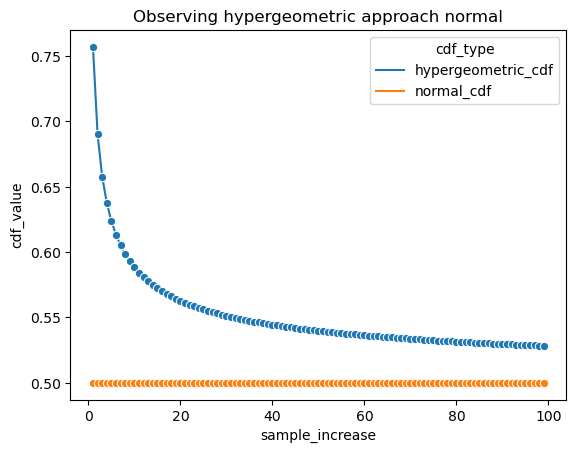

In [5]:
sns.lineplot(x='sample_increase', y='cdf_value', hue='cdf_type', data=compare_and_melt(100), marker='o')
_ = plt.title('Observing hypergeometric approach normal')